# Gradient Boosting Price Prediction

## Project Description

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Initialization

In [1]:
import numpy as np
import pandas as pd
import warnings 

import matplotlib.pyplot as plt
import math
import sklearn.metrics
import sklearn.preprocessing
import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from lightgbm.callback import early_stopping, log_evaluation

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [2]:
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
df = pd.read_csv('/datasets/car_data.csv')

Data shows 16 feature columns. Data contains NaN values.

In [4]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
5,04/04/2016 17:36,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,04/04/2016 00:00,0,33775,06/04/2016 19:17
6,01/04/2016 20:48,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,01/04/2016 00:00,0,67112,05/04/2016 18:18
7,21/03/2016 18:54,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,21/03/2016 00:00,0,19348,25/03/2016 16:47
8,04/04/2016 23:42,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,04/04/2016 00:00,0,94505,04/04/2016 23:42
9,17/03/2016 10:53,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,17/03/2016 00:00,0,27472,31/03/2016 17:17


## Data preparation

For training we will drop non-relevant columns which should not affect price of vehicles listed. 

In [5]:
df_copy = df.copy()

df_clean = df_copy.drop(['DateCrawled', 'PostalCode', 'DateCreated', 'NumberOfPictures', 'LastSeen', 'RegistrationYear', 'RegistrationMonth'], axis=1)

Missing values will be handles with zero values.

In [6]:
df_clean.isna().sum(axis = 0)
df_clean = df_clean.fillna('unknown')
df_clean.isna().sum(axis = 0)

Price          0
VehicleType    0
Gearbox        0
Power          0
Model          0
Mileage        0
FuelType       0
Brand          0
NotRepaired    0
dtype: int64

Datasets are to be encoded for training. Data is to be encoded both ordinaly and with OneHot encode.

In [7]:
# One hot encode data
df_ohe = df_clean.copy().drop(['Model', 'Brand'], axis = 1)

df_ohe = pd.get_dummies(df_ohe, columns = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired'])
print(df_ohe.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   Price                    354369 non-null  int64
 1   Power                    354369 non-null  int64
 2   Mileage                  354369 non-null  int64
 3   VehicleType_bus          354369 non-null  uint8
 4   VehicleType_convertible  354369 non-null  uint8
 5   VehicleType_coupe        354369 non-null  uint8
 6   VehicleType_other        354369 non-null  uint8
 7   VehicleType_sedan        354369 non-null  uint8
 8   VehicleType_small        354369 non-null  uint8
 9   VehicleType_suv          354369 non-null  uint8
 10  VehicleType_unknown      354369 non-null  uint8
 11  VehicleType_wagon        354369 non-null  uint8
 12  Gearbox_auto             354369 non-null  uint8
 13  Gearbox_manual           354369 non-null  uint8
 14  Gearbox_unknown          354369 non-

In [8]:
%%time
# Ordinal encode data
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

df_ord = df_clean.copy()
df_ord[categorical_features] = OrdinalEncoder().fit_transform(df_ord[categorical_features])
df_ord.head()

CPU times: user 733 ms, sys: 31.6 ms, total: 764 ms
Wall time: 764 ms


,Price,VehicleType,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
0,480,7.0,1.0,0,116.0,150000,6.0,38.0,1.0
1,18300,2.0,1.0,190,228.0,125000,2.0,1.0,2.0
2,9800,6.0,0.0,163,117.0,125000,2.0,14.0,1.0
3,1500,5.0,1.0,75,116.0,150000,6.0,38.0,0.0
4,3600,5.0,1.0,69,101.0,90000,2.0,31.0,0.0


In [9]:
# Split data

# Regular
features_train_valid, features_test, target_train_valid, target_test = train_test_split(df_clean.drop('Price', axis = 1), df_clean.Price,  test_size = 0.2, random_state = 12345)
features_train, features_valid, target_train, target_valid = train_test_split(features_train_valid, target_train_valid, test_size = 0.25, random_state = 12345)

# OneHotEncode
features_train_valid_ohe, features_test_ohe, target_train_valid_ohe, target_test_ohe = train_test_split(df_ohe.drop('Price', axis = 1), df_ohe.Price,  test_size = 0.2, random_state = 12345)
features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features_train_valid_ohe, target_train_valid_ohe, test_size = 0.25, random_state = 12345)

# Ordinal
features_train_valid_ord, features_test_ord, target_train_valid_ord, target_test_ord = train_test_split(df_ord.drop('Price', axis = 1), df_ord.Price,  test_size = 0.2, random_state = 12345)
features_train_ord, features_valid_ord, target_train_ord, target_valid_ord = train_test_split(features_train_valid_ord, target_train_valid_ord, test_size = 0.25, random_state = 12345)

Data for this project has been split using 20 percent of data for testing.

## Model training

Trained models are to be evaluated using Root Mean Squared Error.

In [10]:
# Create RMSE scorer
def RMSE(y_true, y_pred):

    rmse = sklearn.metrics.mean_squared_error(y_true, y_pred)**0.5
    return rmse

RMSE_scorer = sklearn.metrics.make_scorer(RMSE, greater_is_better = False)

In [11]:
# train baseline dummy model
pred_mean = np.ones(df_clean['Price'].shape) * df_clean['Price'].mean()
print("Dummy RMSE score:", RMSE(df_clean['Price'], pred_mean).round(5))

Dummy RMSE score: 4514.15214


Dummy score will serve as baseline to ensure models are operational.

### Linear Regression

In [12]:
%%time

# Train for linear regression
model_LR = LinearRegression()

model_LR.fit(features_train_ord, target_train_ord)
pred_LR = model_LR.predict(features_valid_ord)
RMSE_LR = RMSE(target_valid_ord, pred_LR)
print(f"Linear regression RMSE: {RMSE_LR.round(5)}\n")

Linear regression RMSE: 3618.67811

CPU times: user 38.1 ms, sys: 84.9 ms, total: 123 ms
Wall time: 43.2 ms


Basic linear regression score will serve as baseline. Model scores are expected to be lower than linear regression score.

### Random Forest Regressor

In [13]:
%%time

# Train for random forest regressor 
model_RFR = RandomForestRegressor(random_state = 12345)

search_RFR = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 6, 9]}

GS_RFR = GridSearchCV(estimator = model_RFR, 
                     param_grid = search_RFR,
                     scoring = RMSE_scorer,
                     verbose = 0)

GS_RFR.fit(features_train_ord, target_train_ord)

CPU times: user 8min 42s, sys: 1.22 s, total: 8min 43s
Wall time: 8min 44s


GridSearchCV(estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [3, 6, 9],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [14]:
RFR_pred = GS_RFR.best_estimator_.predict(features_valid_ord)
RMSE_RFR = RMSE(target_valid_ord, RFR_pred)

In [15]:
# Print best params/score
print("Random forest regressor best parameters:", GS_RFR.best_params_)
print("Best RMSE Random forest regressor:", RMSE_RFR.round(5))

Random forest regressor best parameters: {'max_depth': 9, 'n_estimators': 200}
Best RMSE Random forest regressor: 2601.75303


### LightGBM

In [16]:
%%time

features_train_cat = features_train[categorical_features].astype('category')
features_valid_cat = features_valid[categorical_features].astype('category')
features_test_cat = features_test[categorical_features].astype('category')

# Train LightGBM
model_LGBM = lgb.LGBMRegressor(random_state = 12345)

search_LGBM = {
    "n_estimators": [500],
    "learning_rate": [0.1]}

fit_params = {'eval_set': [(features_valid_cat, target_valid)], 
             'callbacks': [log_evaluation(period=0)]}

grid_LGBM = GridSearchCV(estimator = model_LGBM,
                        param_grid = search_LGBM,
                        scoring = RMSE_scorer)

grid_LGBM.fit(features_train_cat, target_train, **fit_params)

CPU times: user 44min 15s, sys: 6.24 s, total: 44min 22s
Wall time: 22min 13s


GridSearchCV(estimator=LGBMRegressor(random_state=12345),
             param_grid={'learning_rate': [0.1], 'n_estimators': [500]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [17]:
LGBM_pred = grid_LGBM.best_estimator_.predict(features_valid_cat)
RMSE_LGBM = RMSE(target_valid, LGBM_pred)

In [18]:
# Print best params/score
print("LightGBM best parameters:", grid_LGBM.best_params_)
print("Best RMSE LightLGBM:", RMSE_LGBM.round(5))

LightGBM best parameters: {'learning_rate': 0.1, 'n_estimators': 500}
Best RMSE LightLGBM: 3318.90019


### CatBoost

In [19]:
%%time 

# Train LightGBM
model_CB = CatBoostRegressor(cat_features = categorical_features, verbose = False, random_state = 12345)

GS_CB = {
    "n_estimators": [500],
    "learning_rate": [0.1]}

GS_CB = GridSearchCV(estimator = model_CB, 
                     param_grid = GS_CB,
                     scoring = RMSE_scorer)

GS_CB.fit(features_train, target_train, eval_set = (features_valid, target_valid))

CPU times: user 9min 8s, sys: 5.12 s, total: 9min 13s
Wall time: 5min 13s


GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7f52800fea30>,
             param_grid={'learning_rate': [0.1], 'n_estimators': [500]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [20]:
CB_pred = GS_CB.best_estimator_.predict(features_valid)
RMSE_RFR = RMSE(target_valid, CB_pred)

In [21]:
# Print best params/score
print("Catboost best parameters:", GS_RFR.best_params_)
print("Best RMSE CatBoost:", RMSE_RFR.round(5))

Catboost best parameters: {'max_depth': 9, 'n_estimators': 200}
Best RMSE CatBoost: 2302.14254


### XGBoost

In [22]:
%%time 

# Train LightGBM
model_XGB = xgb.XGBRegressor(verbosity = 0, random_state = 12345)

GS_XGB = {
    "n_estimators": [500],
    "learning_rate": [0.1]}

GS_XGB = GridSearchCV(estimator = model_XGB, 
                     param_grid = GS_XGB,
                     scoring = RMSE_scorer)

GS_XGB.fit(features_train_ohe, target_train_ohe, eval_set = [(features_valid_ohe, target_valid_ohe)], verbose = 0)

CPU times: user 1h 9min 55s, sys: 9 s, total: 1h 10min 4s
Wall time: 35min 4s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=12345, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                         

In [23]:
XGB_pred = GS_XGB.best_estimator_.predict(features_valid_ohe)
RMSE_XGB = RMSE(target_valid_ohe, XGB_pred)

In [24]:
# Print best params/score
print("XGBoost best parameters:", GS_XGB.best_params_)
print("Best RMSE XGBoost:", RMSE_XGB.round(5))

XGBoost best parameters: {'learning_rate': 0.1, 'n_estimators': 500}
Best RMSE XGBoost: 2491.87525


Model scores have been obtained and pass the baseline scoreing comparision.

## Model analysis

Best model estimators will now predict testing data.

### Linear Regression

In [25]:
# Predict test data
pred_LR_test = model_LR.predict(features_test_ord)
RMSE_LR_test = RMSE(target_test_ord, pred_LR_test)
print(RMSE_LR_test.round(5))

3624.52204


### Random Forest Regressor

In [26]:
# Predict test data
pred_RFR_test = GS_RFR.best_estimator_.predict(features_test_ord)
RMSE_RFR_test = RMSE(target_test_ord, pred_RFR_test)
print(RMSE_RFR_test.round(5))

2627.96892


### LightGBM 

In [27]:
# Predict test data
pred_LGBM_test = grid_LGBM.best_estimator_.predict(features_test_cat)
RMSE_LGBM_test = RMSE(target_valid, pred_LGBM_test)
print(RMSE_LGBM_test.round(5))

5443.82502


LightGBM testing score displays potential overfitting, does not pass baseline score.

### Catboost

In [28]:
# Predict test data
CB_pred_test = GS_CB.best_estimator_.predict(features_test)
RMSE_CB_test = RMSE(target_test, CB_pred_test)
print(RMSE_CB_test.round(5))

2324.47647


### XGBoost

In [29]:
# Predict test data
XGB_pred_test = GS_XGB.best_estimator_.predict(features_test_ohe)
RMSE_XGB_test = RMSE(target_test_ohe, XGB_pred_test)
print(RMSE_XGB_test.round(5))

2511.47088


### Model Comparison

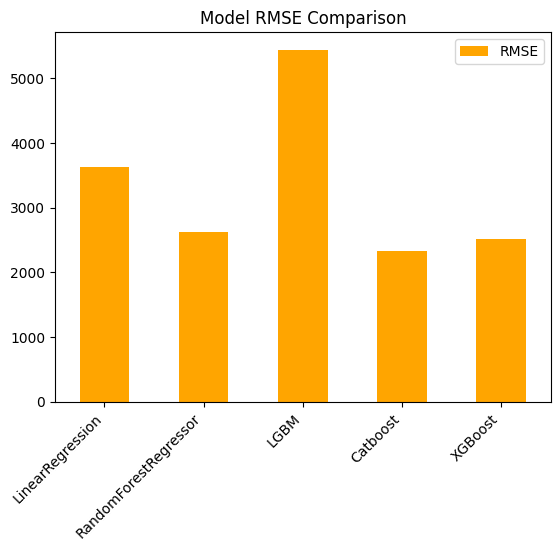

In [30]:
# Plot RMSE for different models
RMSE_scores = [RMSE_LR_test, RMSE_RFR_test, RMSE_LGBM_test, RMSE_CB_test, RMSE_XGB_test]
RMSE_df = pd.DataFrame(data=RMSE_scores, index=['LinearRegression', 'RandomForestRegressor', 'LGBM', 'Catboost', 'XGBoost'], columns=['RMSE'])
RMSE_df.plot(kind = 'bar', title = 'Model RMSE Comparison', color = 'Orange')

plt.xticks(rotation=45, ha='right')
plt.show()

### Conclusion

RMSE comparision between models shows CatBoost to be the most viable model to use for this task. 